In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA
from lib.data import semi_empirical_mass_formula, BW2_mass_formula
import seaborn as sns
from lib.data import semi_empirical_mass_formula, BW2_mass_formula
sns.set_style('darkgrid')
sns.set_context('paper')

In [2]:
import glob
locations = glob.glob('/export/d0/kitouni/data/experiments/long-runs/*')

keys = [l.split('/')[-1].split('-')[1] for l in locations]
def cleanup(name):
    if '+' in name: return 'all'
    while name[-1].isdigit() or name[-1] == '.':
        name = name[:-1]
    return name
keys = [cleanup(k) for k in keys]
locations = {key:l for key, l in zip(keys, locations)}
task_rms_values = {}

# Explorations

In [3]:
def inverse_transform(tensor, data):
    min_ = torch.from_numpy(data.regression_transformer.data_min_).to(tensor.device)
    max_ = torch.from_numpy(data.regression_transformer.data_max_).to(tensor.device)
    return tensor * (max_ - min_) + min_

def get_preds(X, model, data, batch = 200):
    preds = torch.zeros(X.shape[0], 1).to(X.device)
    with torch.no_grad():
        for i in range(0, X.shape[0], batch):
            preds_ = inverse_transform(model(X[i:i+batch]), data)
            preds_ = torch.gather(preds_, 1, X[i:i+batch, [2]])
            preds[i:i+batch] = preds_
    return preds

def get_rms(X, y, model, data):
    preds = get_preds(X, model, data)
    rms = {}
    for i, task_name in enumerate(data.output_map):
        task_mask = X[:, 2] == i
        rms[task_name] = torch.sqrt(torch.mean((preds[task_mask] - y[task_mask])**2)).item()
    return rms

## Embeddings

/work/submit/kitouni/code/NuCLR-MechInterp/lib/utils.py:106: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(15*figscale, 3 * num_components*figscale))


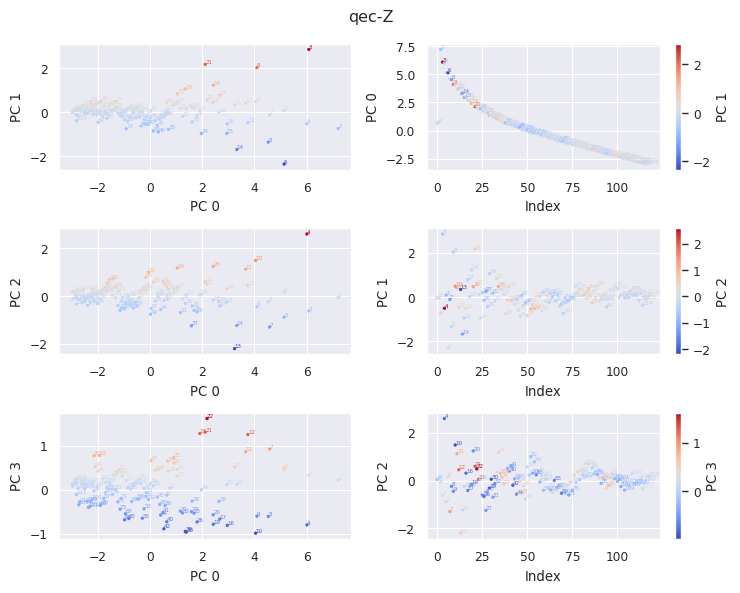

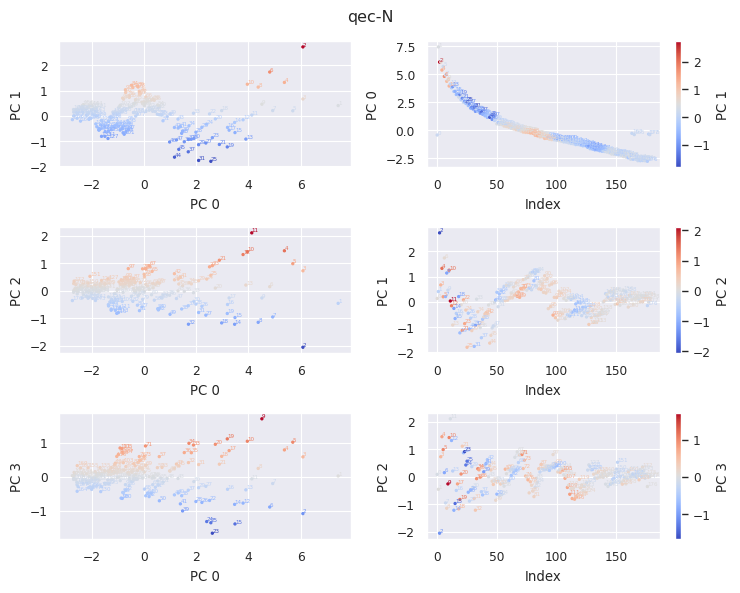

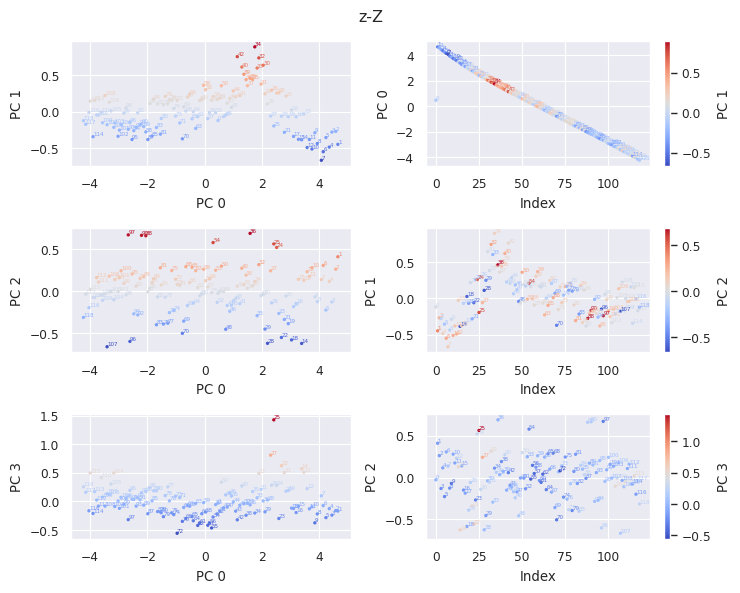

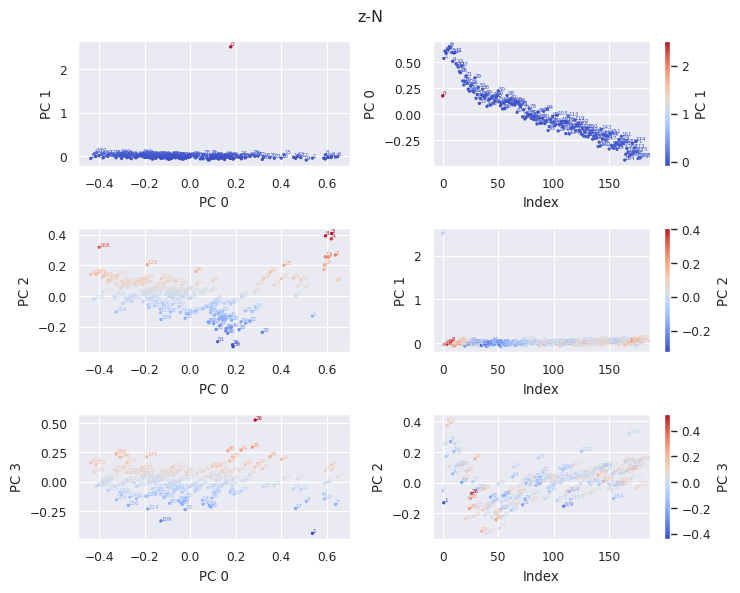

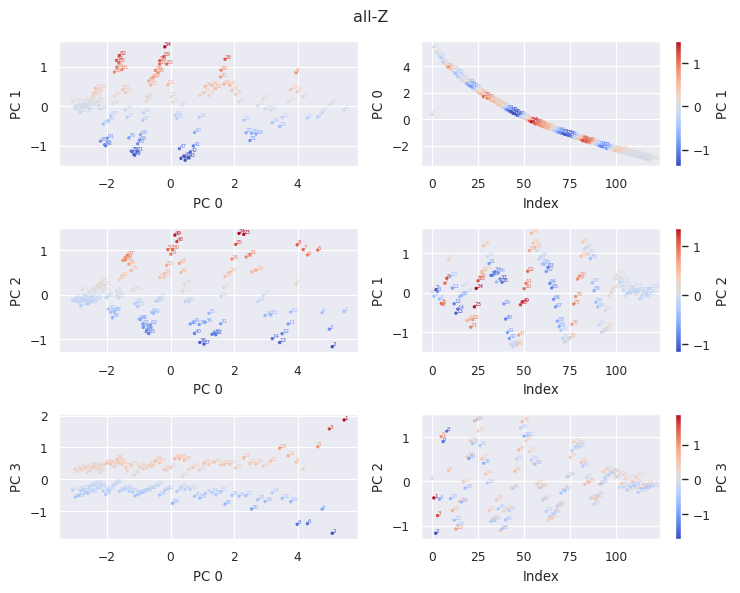

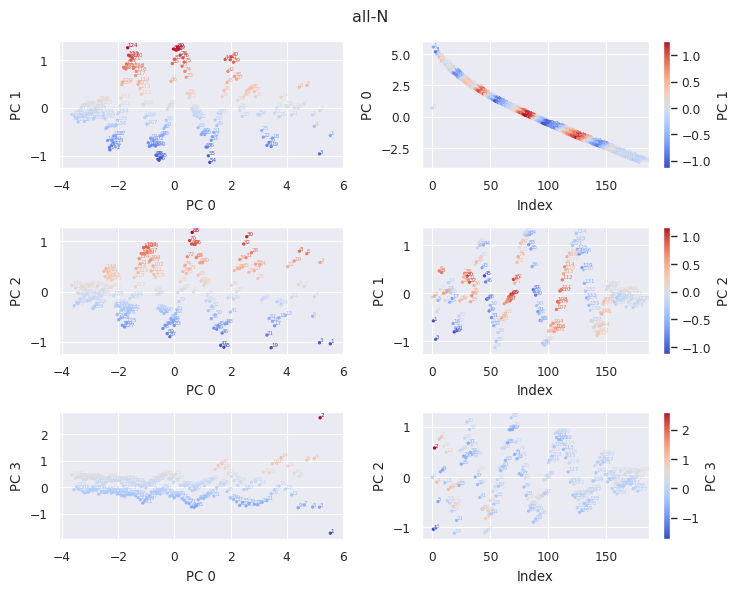

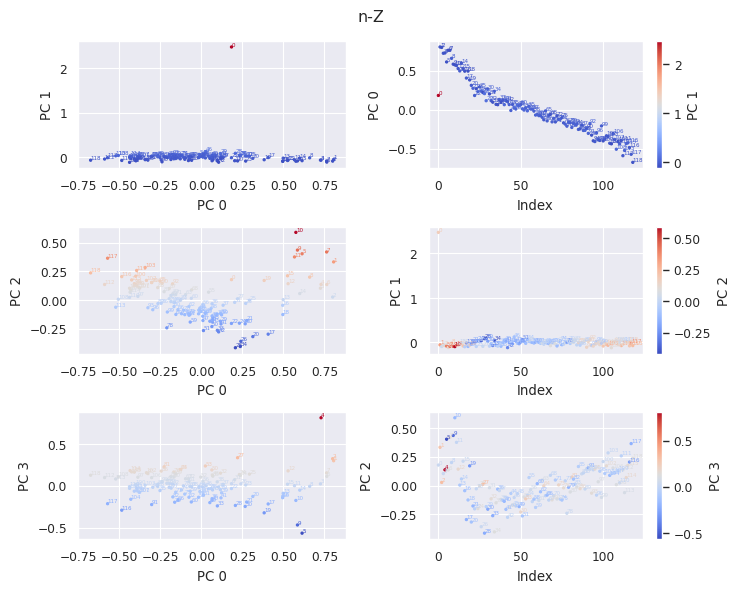

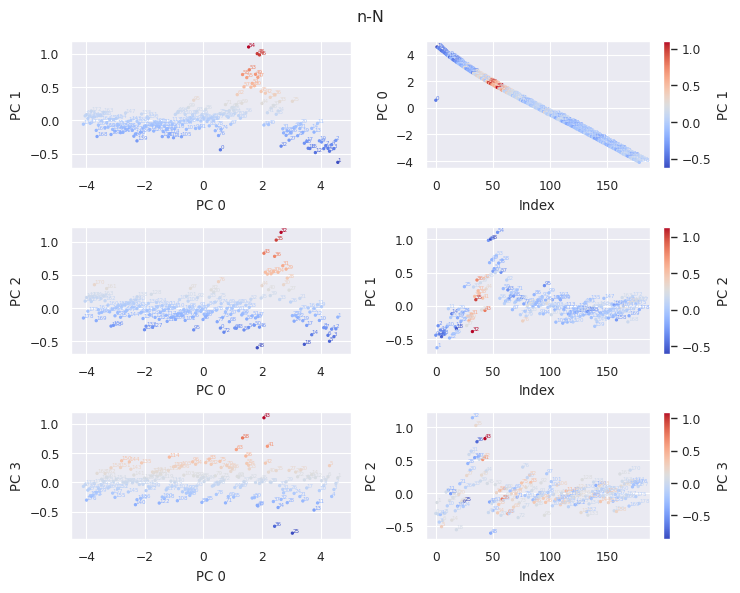

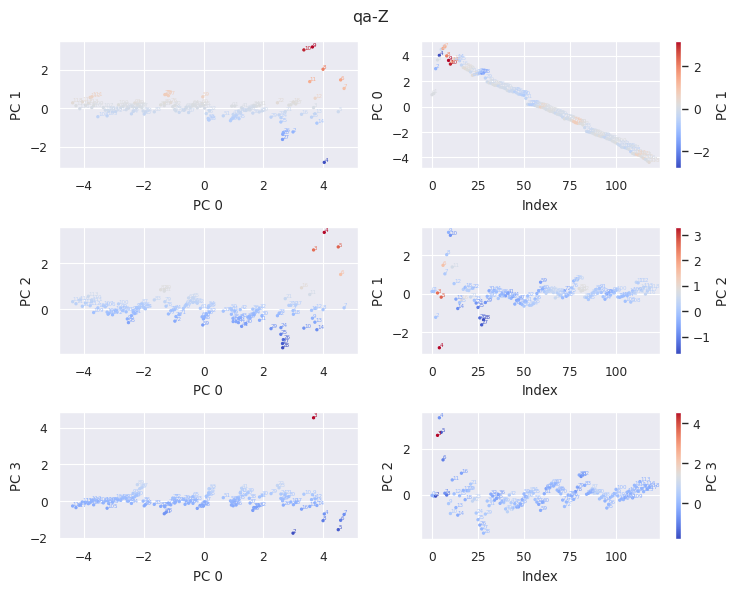

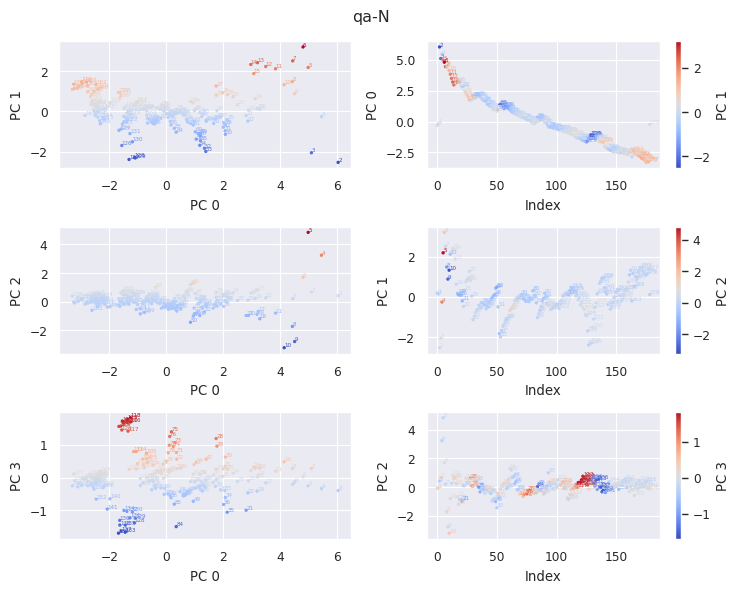

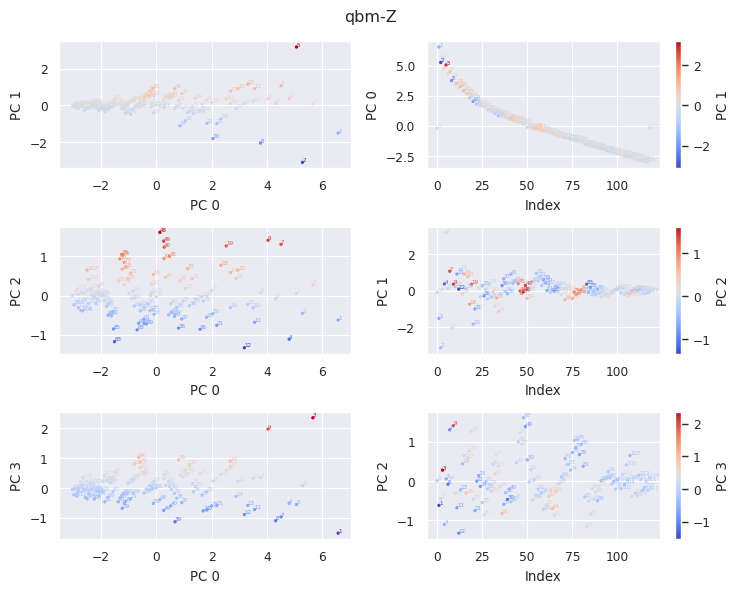

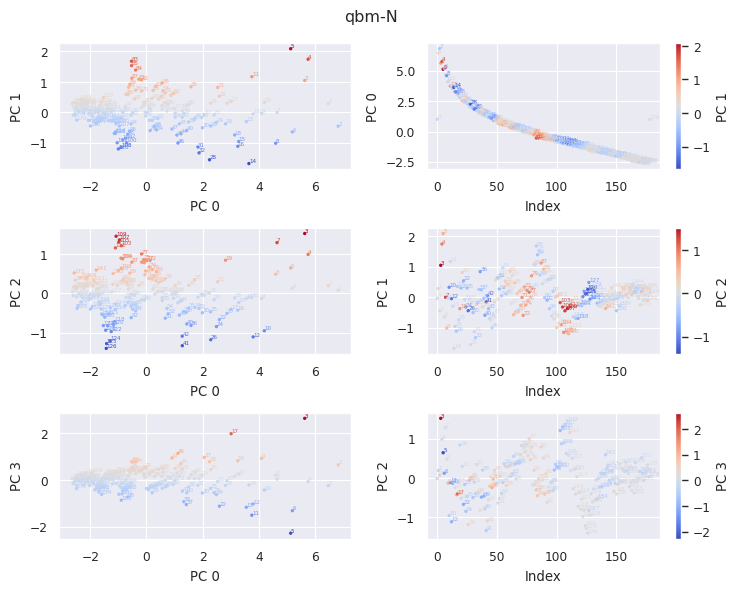

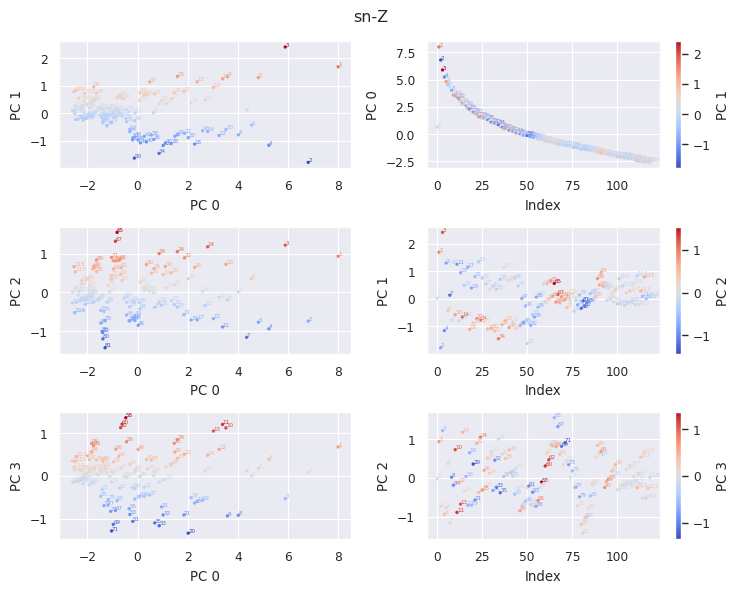

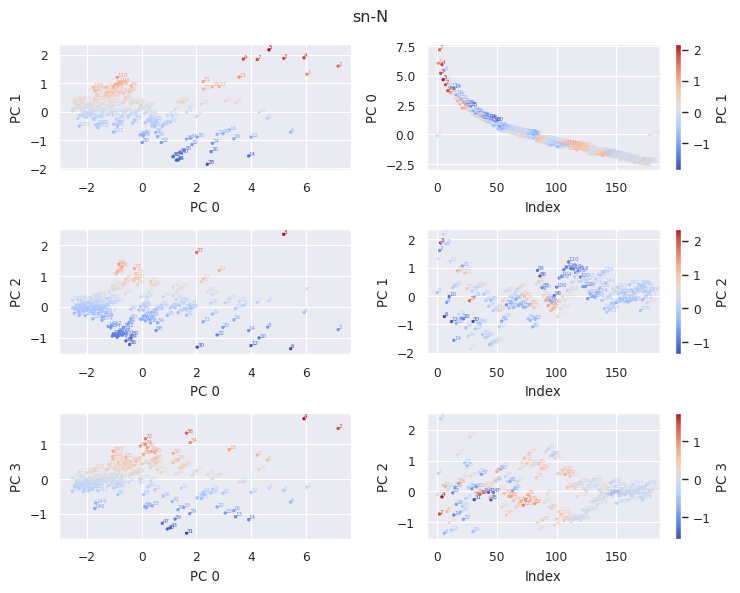

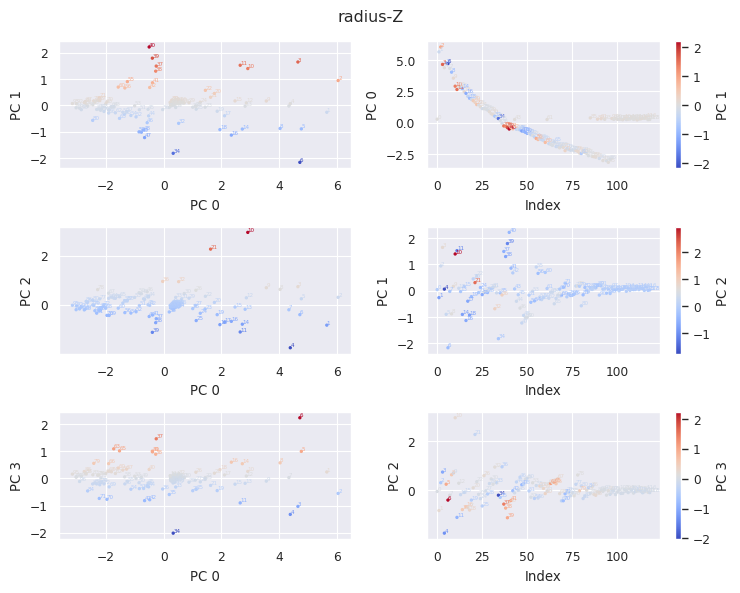

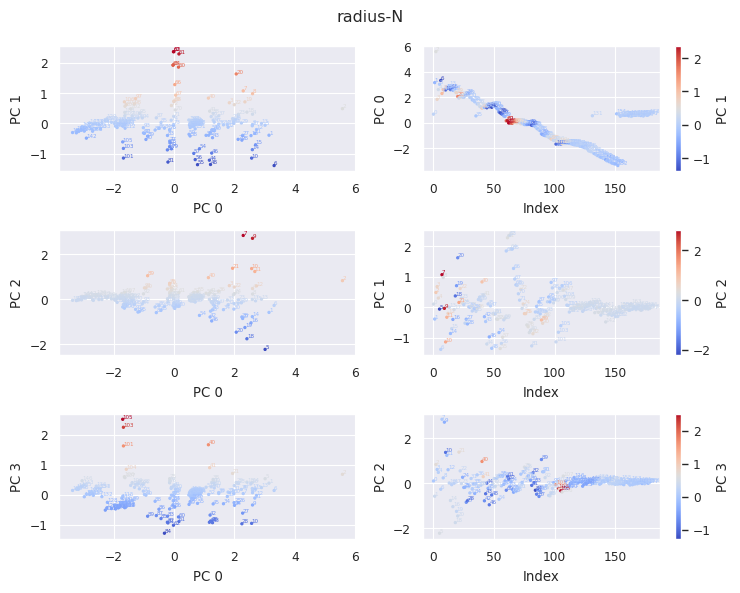

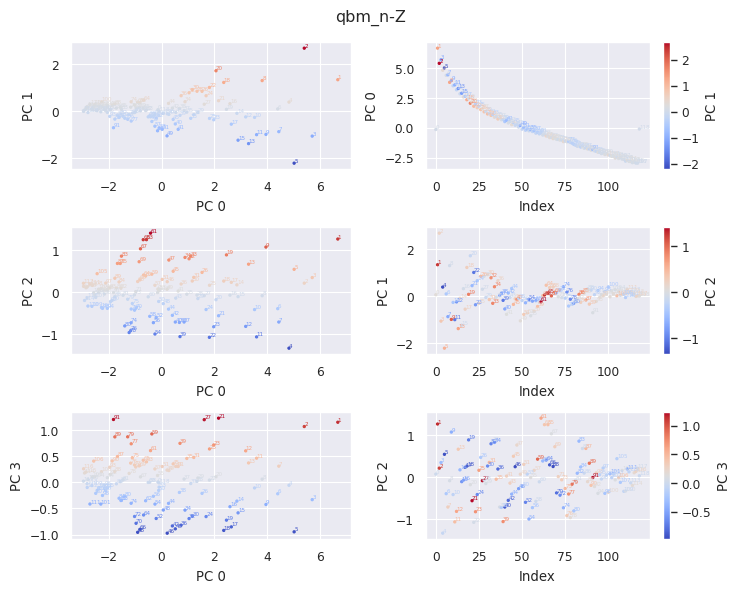

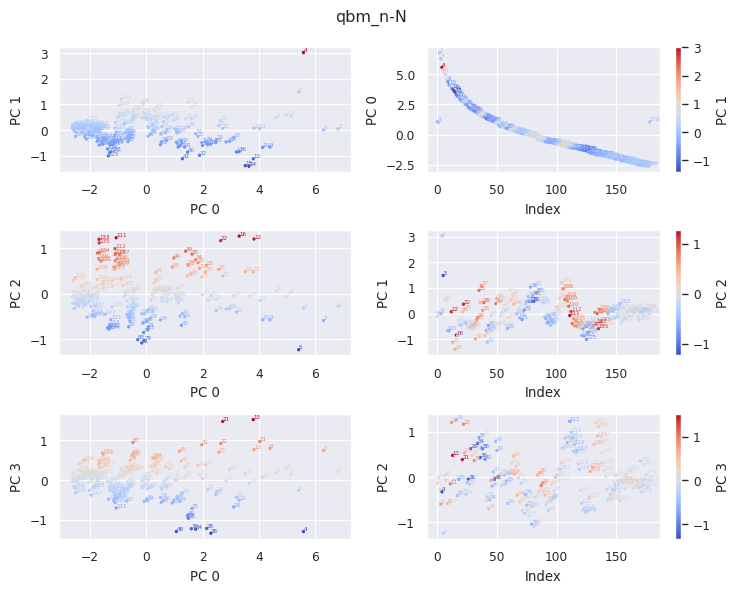

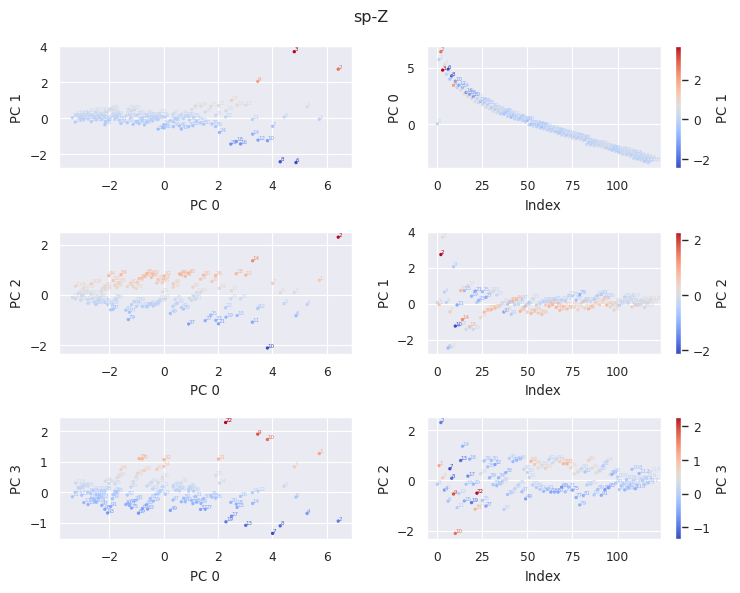

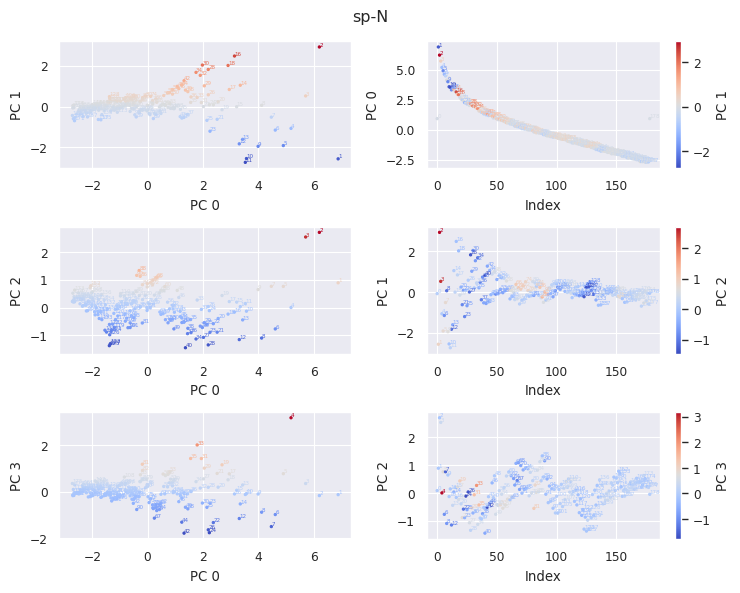

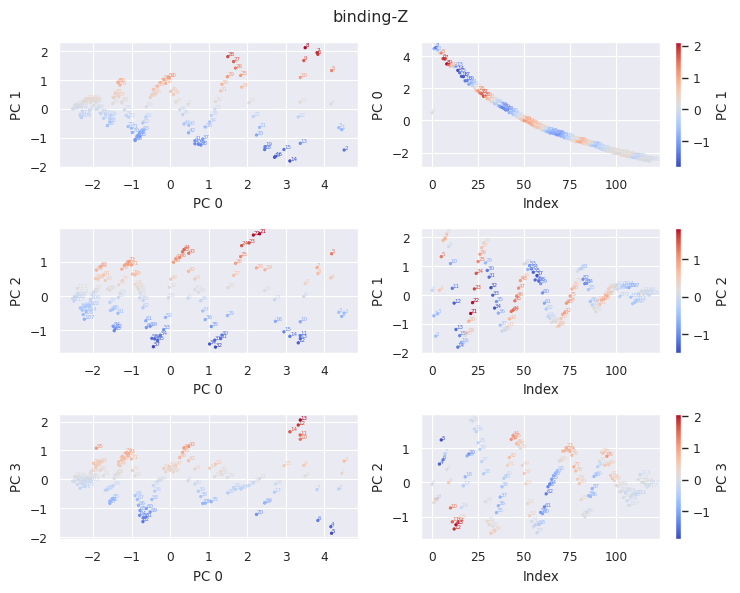

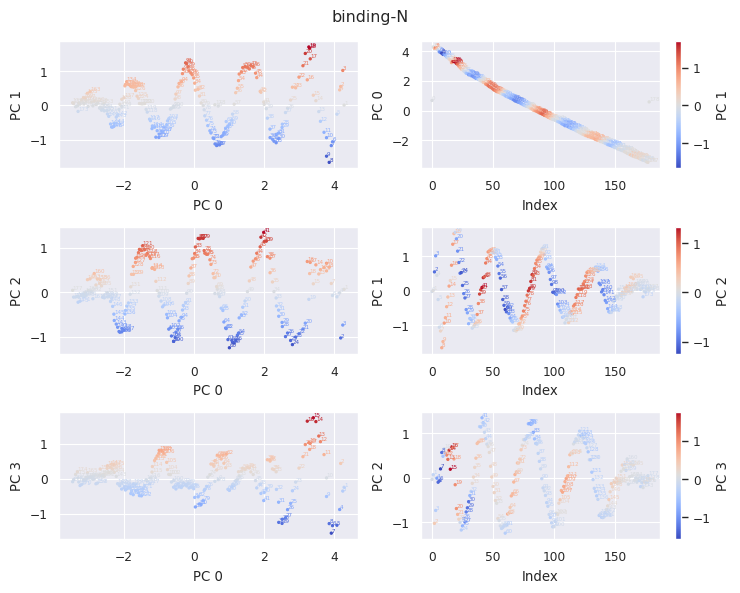

In [4]:
os.makedirs('plots/long-runs', exist_ok=True)
for key, location in locations.items():
    args = IO.load_args(f"{location}/args.yaml")
    args.DEV = "cpu"
    data = prepare_nuclear_data(args)
    model = get_model_and_optim(data, args)[0]
    model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

    # get RMS for each task
    mask = data.val_mask & ~torch.isnan(data.y[:, 0])
    X_val = data.X[mask]
    y_val = data.y[mask]

    mask = data.train_mask & ~torch.isnan(data.y[:, 0])
    X_train = data.X[mask]
    y_train = data.y[mask]
        
    rms_train = get_rms(X_train, y_train, model, data)
    rms_val = get_rms(X_val, y_val, model, data)
    task_rms_values[key] = (rms_train, rms_val)
    
    nucleon = "ZN"
    for i in range(2):
        emb = model.emb[i].detach().numpy()
        fig = PlottingContext.plot_embedding(emb, num_components=4, figscale=0.5)
        fig.suptitle(key+f"-{nucleon[i]}"); fig.tight_layout()
        fig.savefig(f'plots/long-runs/{key}-{nucleon[i]}-emb.pdf', bbox_inches='tight')

## Features

In [4]:
model_name = 'all'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

mask = data.train_mask & ~torch.isnan(data.y[:, 0])
X_train = data.X[mask]
y_train = data.y[mask]

Loading model from /export/d0/kitouni/data/experiments/long-runs/long_run-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0/ckpts/model.pt


In [5]:
def get_penultimate_acts(model, X):
    # Save the last layer activations
    acts = torch.zeros(len(X), args.HIDDEN_DIM, device=args.DEV)
    # save the activations fed into the readout layer
    hook = model.readout.register_forward_pre_hook(
        lambda m, i: acts.copy_(i[0].detach())
    )
    model(X)
    hook.remove()
    return acts

def output_to_rms(output, data, X):
    preds = inverse_transform(output, data)
    preds = preds.gather(1, X[:, 2].long().view(-1, 1))
    return np.sqrt(np.mean((preds.detach().cpu().numpy() - y.detach().cpu().numpy()) ** 2))
    

X = data.X
y = data.y
mask = lambda x: x[(X[:, 2] == 0) & ~torch.isnan(y.view(-1))]
X, y = mask(X), mask(y)

acts = get_penultimate_acts(model, X)
rms = output_to_rms(model.readout(acts), data, X)
print(f"RMS of readout layer: {rms:.2f}")

RMS of readout layer: 270.09


In [6]:
# linear regression from activations to output to compare with the readout layer
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(acts.detach().cpu().numpy(), y.detach().cpu().numpy())
lr_preds = reg.predict(acts.detach().cpu().numpy())
rms = np.sqrt(np.mean((lr_preds - y.detach().cpu().numpy()) ** 2))
print(f"RMS of linear regression: {rms:.2f}")

RMS of linear regression: 19.13


How is the linear regression prediction so much better?

In [7]:
model_norm = np.linalg.norm(model.readout.weight[0].detach().numpy())
lin_reg_norm = np.linalg.norm(reg.coef_)
print(f"Norm of readout layer: {model_norm:.2f}, norm of linear regression weights: {lin_reg_norm:.2f}")

Norm of readout layer: 3.30, norm of linear regression weights: 881559.06


Text(0, 0.5, 'RMS [keV]')

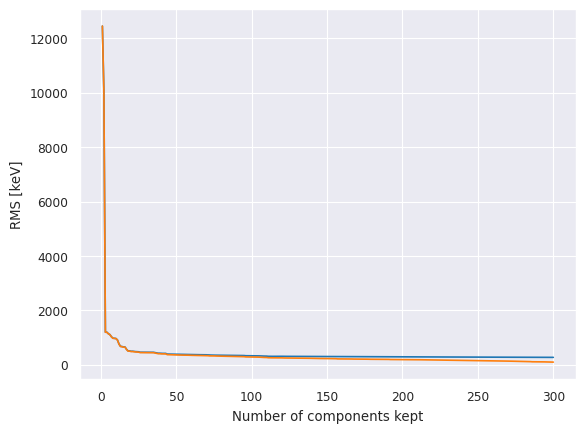

In [11]:
n_components = 300
pca = PCA(n_components=n_components)
pca.fit(acts.cpu().numpy())

# project to first n components
ns = np.arange(1, n_components+1)
rms_by_n, rms_ling_alg_by_n = {}, {}
for n in ns:
    acts_pca = pca.transform(acts.cpu().numpy())
    acts_pca[:, n:] = 0
    acts_ = pca.inverse_transform(acts_pca)
    acts_ = torch.tensor(acts_, device=args.DEV)
    rms = output_to_rms(model.readout(acts_), data, X)
    # lin regression rms:
    lr_preds = reg.predict(acts_)
    rms_ling_alg = np.sqrt(np.mean((lr_preds - y.detach().cpu().numpy()) ** 2))
    rms_by_n[n] = rms
    rms_ling_alg_by_n[n] = rms_ling_alg

plt.plot(ns, rms_by_n.values(), label='readout layer')
plt.plot(ns, rms_ling_alg_by_n.values(), label='linear regression')
plt.xlabel("Number of components kept")
plt.ylabel("RMS [keV]")

In [12]:
pca.fit(acts.cpu().numpy())
acts_pca = pca.transform(acts.cpu().numpy())
features = []
for i in range(20):
    acts_pca_ = np.zeros_like(acts_pca)
    # set everything to zero except the ith component
    acts_pca_[:, i] = acts_pca[:, i]
    acts_ = pca.inverse_transform(acts_pca_)
    acts_ = torch.tensor(acts_, device=args.DEV)
    feat = reg.predict(acts_)
    features.append(feat)
features = np.hstack(features)

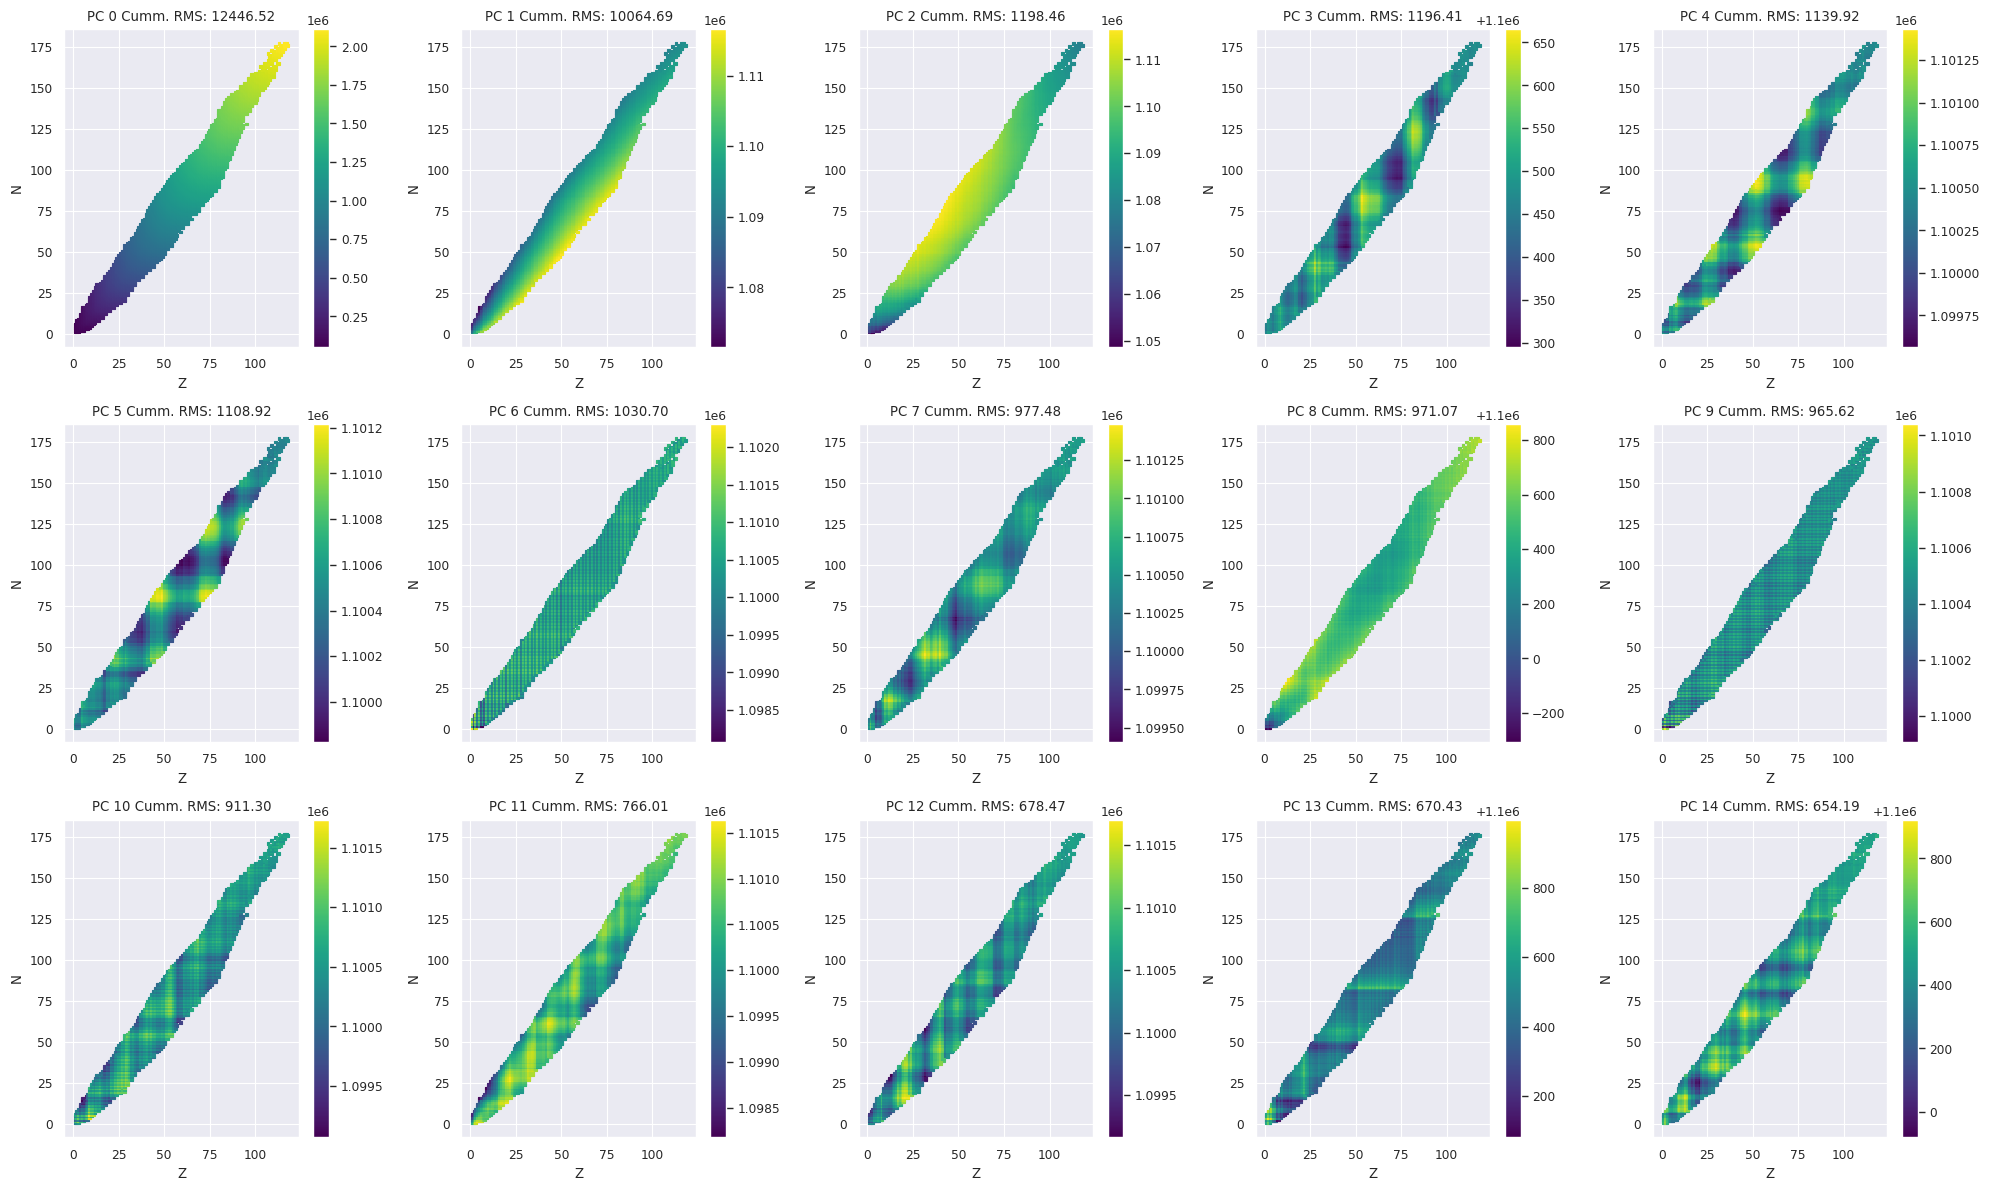

In [13]:
Z, N = X[:, :2].detach().cpu().numpy().T

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for i in range(len(axes.flatten())):
    ax = axes[i//5, i%5]
    plt.sca(ax)
    plt.scatter(Z, N, c=features[:, i], cmap="viridis", s=4, marker="s")
    plt.xlabel("Z")
    plt.ylabel("N")
    plt.title(f"PC {i} Cumm. RMS: {rms_by_n[i+1]:.2f}")
    plt.colorbar()
fig.tight_layout()
# fig.savefig(f"plots/long-runs/{model_name}/PCA-features.pdf")
plt.show()

# Paper plots

In [15]:
from lib.utils import Physics
physics_terms = {func: getattr(Physics, func)(Z, N) for func in Physics.all_funcs}

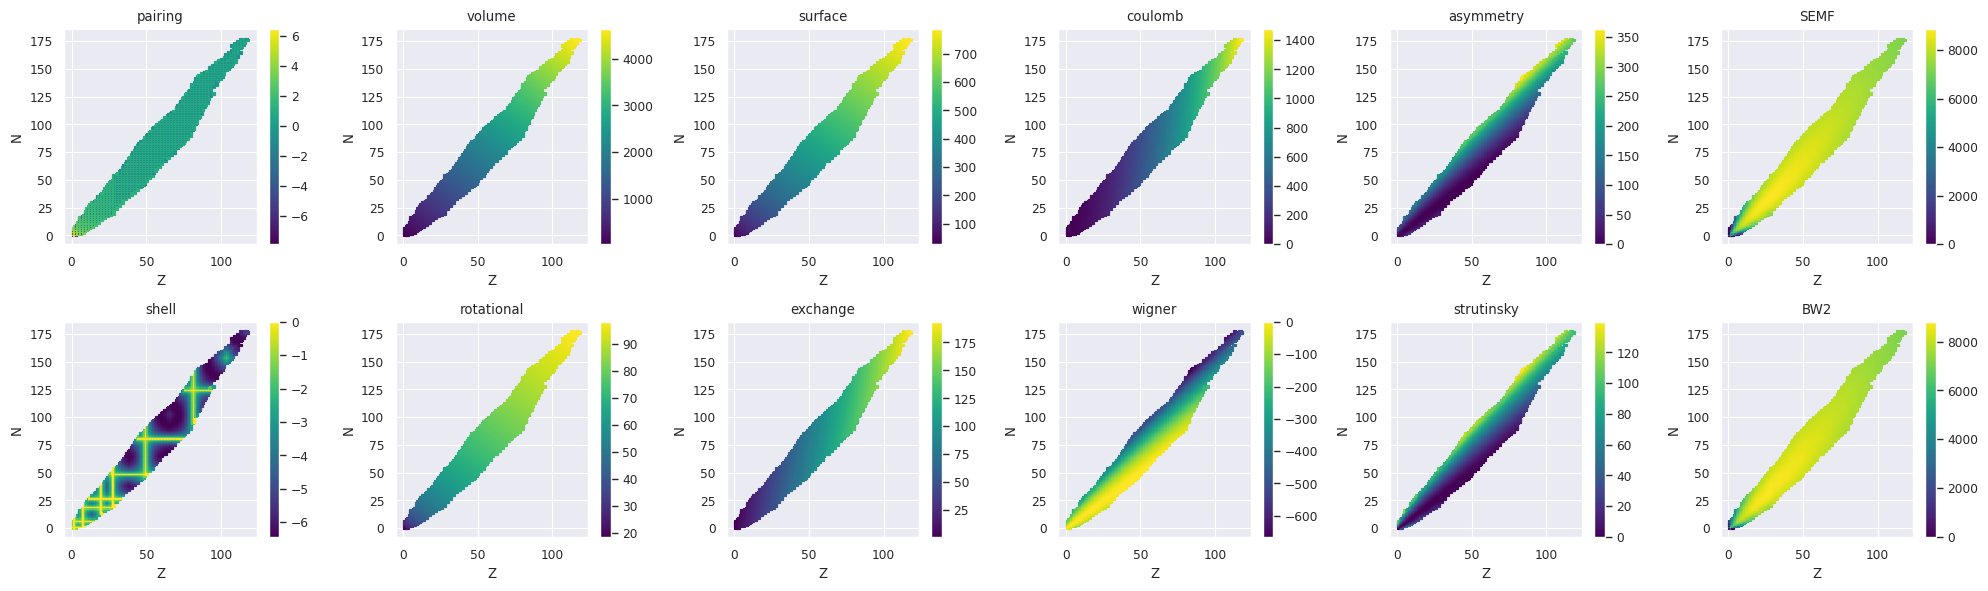

In [16]:
fig, axes = plt.subplots(2, 6, figsize=(20, 6))
for ax, func in zip(axes.flatten(), physics_terms):
    plt.sca(ax)
    plt.scatter(Z, N, c=physics_terms[func], cmap="viridis", s=4, marker="s")
    plt.xlabel("Z"); plt.ylabel("N"); plt.title(func); plt.colorbar()
fig.tight_layout()

/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


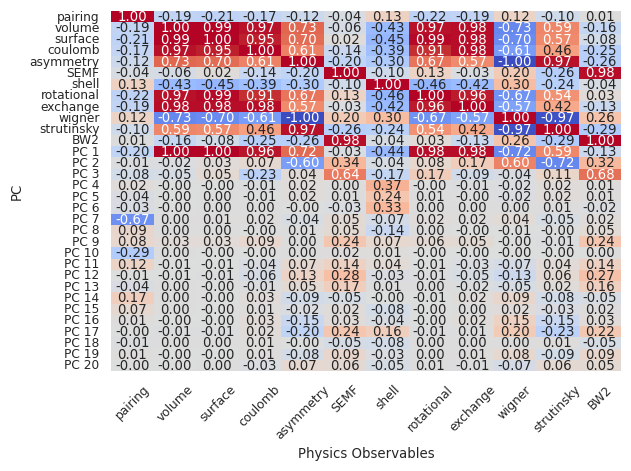

In [17]:
STAND = False
# cosine sim between terms
nn_features = features.T #/ (N+Z)
# nn_features = acts.cpu().detach().numpy().T[:30]
physics_features = np.stack(physics_terms.values()) #* (N+Z)
# standardize
standard = lambda x: (x - x.mean(1, keepdims=True))/x.std(1, keepdims=True)
if STAND:
    nn_features = standard(nn_features)
    physics_features = standard(physics_features)

R = np.corrcoef(physics_features, nn_features, rowvar=True) # compute var across rows

corr_mat = R[:physics_features.shape[0], -nn_features.shape[0]:]


corr_mat_long = R[:physics_features.shape[0]]
y_ticks = list(physics_terms.keys()) + [f"PC {i}" for i in range(1, nn_features.shape[0]+1)]
# plot
fig, ax = plt.subplots()
# sns.heatmap(corr_mat.T, ax=ax, cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
sns.heatmap(corr_mat_long.T, ax=ax, cmap='coolwarm', annot=True, fmt='.2f', cbar=False); ax.set_yticks(np.arange(len(y_ticks))+0.5, labels=y_ticks, rotation=0)
ax.set_xticklabels(Physics.all_funcs, rotation=45)
ax.set_xlabel("Physics Observables")
ax.set_ylabel("PC")
plt.tight_layout()

# plt.savefig(f"plots/paper/{model_name}_correlation_matrix.pdf")

Text(49.91666666666667, 0.5, 'PC')

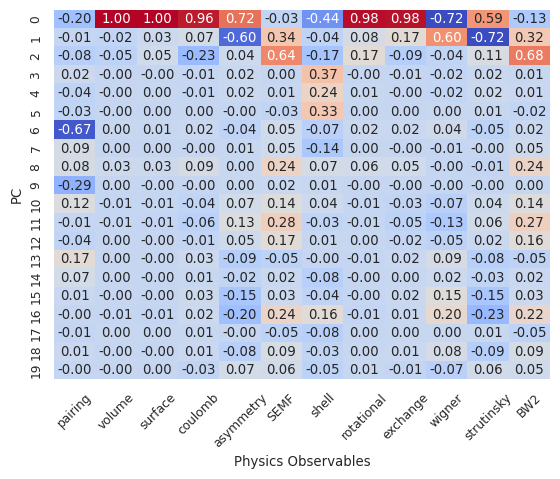

In [26]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression

def get_correlations(physics_features, nn_features, corr_func):
    corr_mat = np.zeros((physics_features.shape[0], nn_features.shape[0]))
    for i in range(physics_features.shape[0]):
        for j in range(nn_features.shape[0]):
            if corr_func == mutual_info_regression:
                corr_mat[i, j] = corr_func(nn_features[j].reshape(-1, 1), physics_features[i]).item()
            else:
                corr_mat[i, j] = corr_func(physics_features[i], nn_features[j]).correlation
    return corr_mat

corr_mat = get_correlations(physics_features, nn_features, pearsonr)
# imshow the correlation matrix
fig, ax = plt.subplots()
sns.heatmap(corr_mat.T, ax=ax, cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
ax.set_xticklabels(Physics.all_funcs, rotation=45)
ax.set_xlabel("Physics Observables")
ax.set_ylabel("PC")


In [27]:
# # save pca features
# znf = np.column_stack([Z, N, nn_features.T]).T
# np.save(f"plots/long-runs/{model_name}/pca_features.npy", znf)

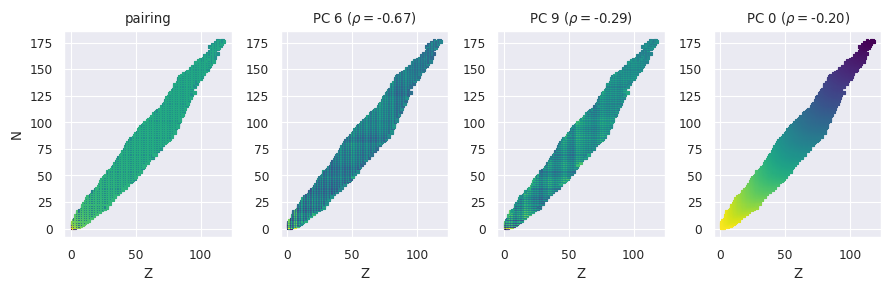

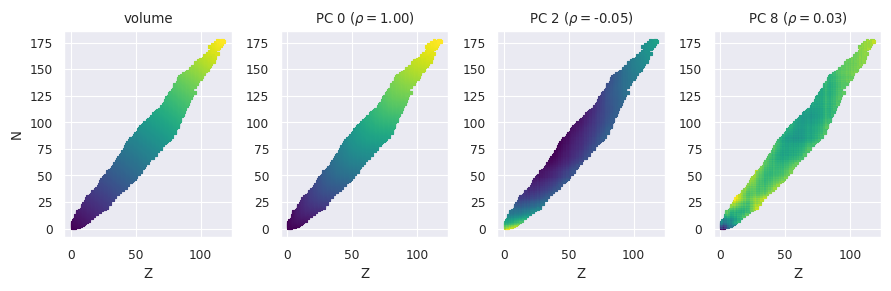

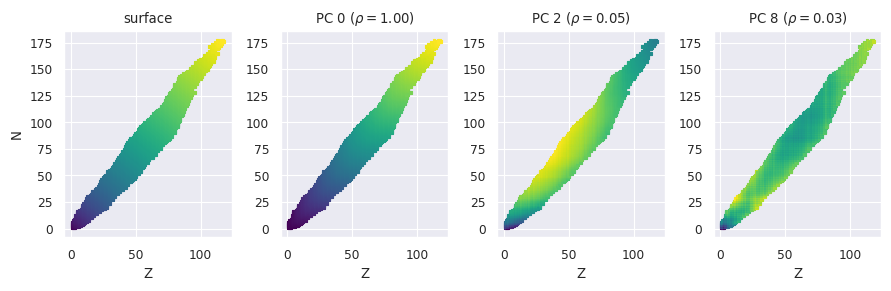

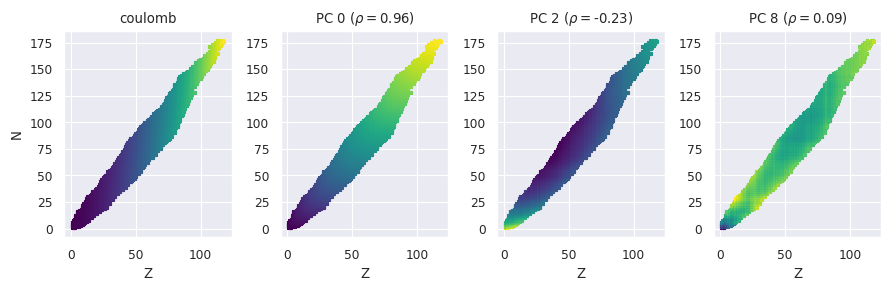

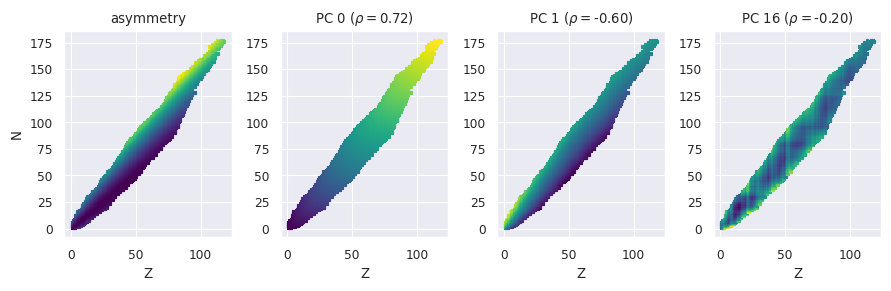

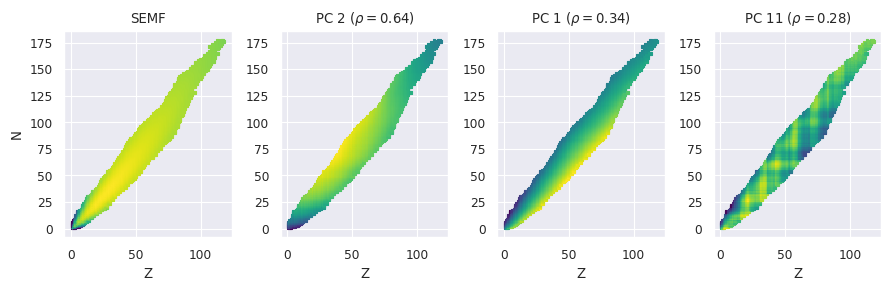

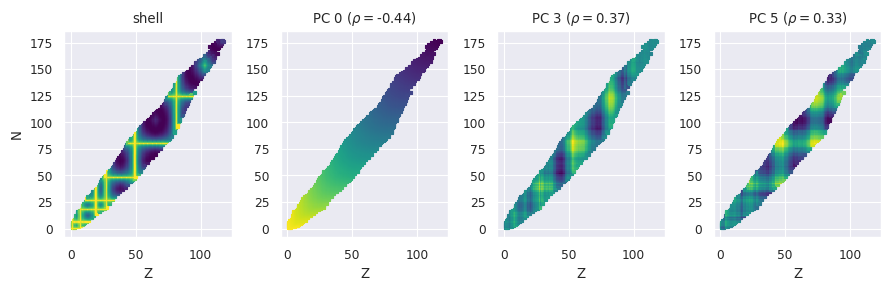

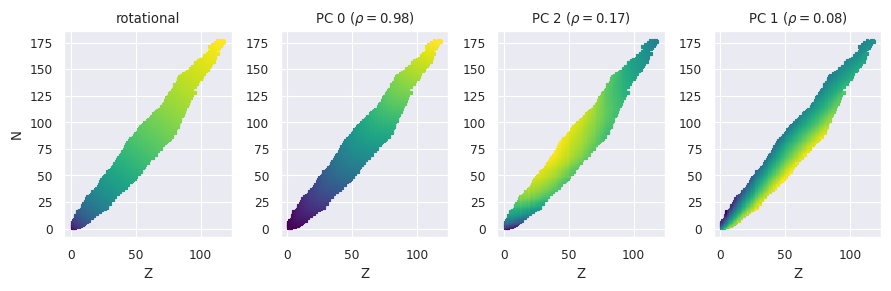

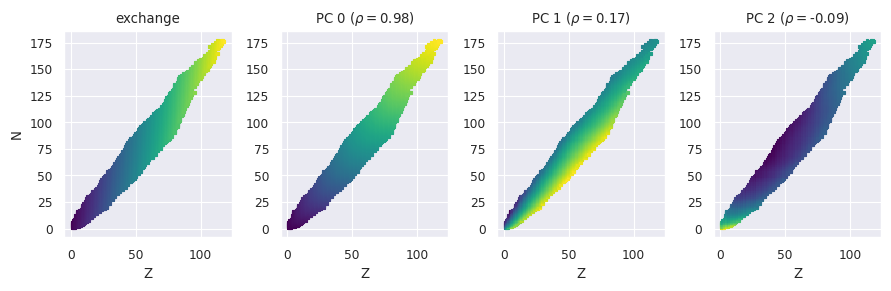

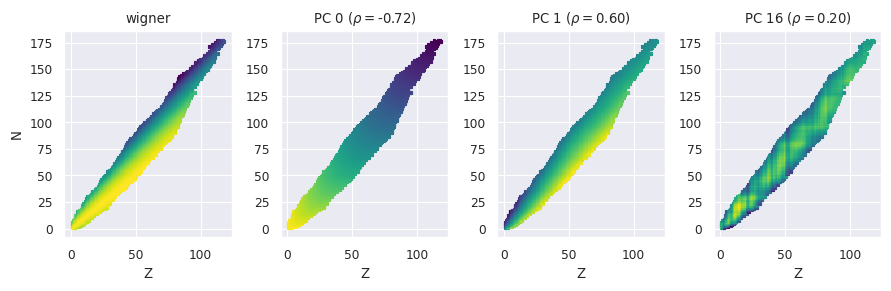

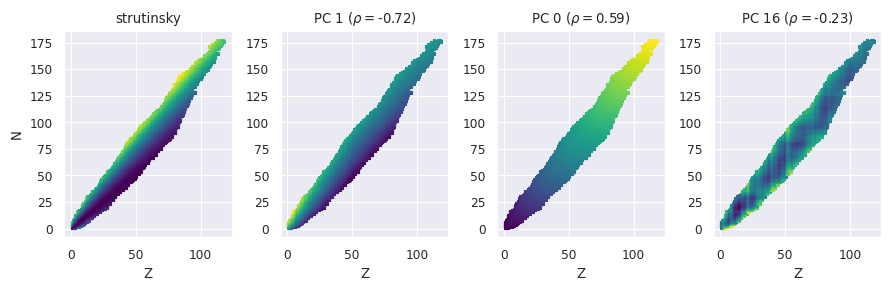

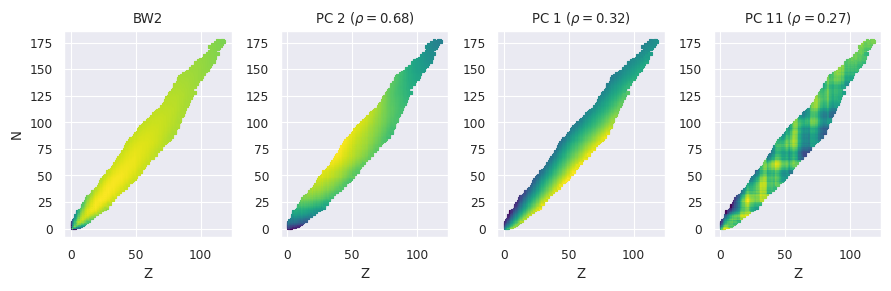

In [28]:
# obtain the topk highest PCs for each physcis term
topk = 3
topk_idxs = np.argsort(np.abs(corr_mat), axis=1)[:, -topk:][:, ::-1]
# get the corresponding values
topk_vals = corr_mat[np.arange(corr_mat.shape[0])[:, None], topk_idxs]
# get the corresponding nn features
topk_nn = nn_features[topk_idxs, :]
# plot
for i, term in enumerate(physics_terms):
    fig, axes = plt.subplots(1, topk+1, figsize=(3*topk, 3))
    plt.sca(axes[0]); plt.scatter(Z, N, c=physics_terms[term], cmap="viridis", s=4, marker="s"); plt.title(term); plt.xlabel("Z"); plt.ylabel("N")
    for j, ax in enumerate(axes.flatten()[1:]):
        plt.sca(ax)
        corr = topk_vals[i, j]
        plt.scatter(Z, N, c=topk_nn[i, j]*np.sign(corr), cmap="viridis", s=4, marker="s")
        plt.xlabel("Z"); plt.title(f"PC {topk_idxs[i, j]} "r"($\rho=$"f"{corr:.2f})")
        # plt.colorbar()
    fig.tight_layout()
    plt.show()


## Matches Plot

In [29]:
# imshow from X, Y and color
def imshow(X, Y, C, ax=None, **kwargs):
    """make an imshow without using a scatter"""
    if ax is None:
        ax = plt.gca()
    # get the extent
    extent = (X.min(), X.max(), Y.min(), Y.max())
    # make the grid
    xgrid, ygrid = np.meshgrid(np.linspace(X.min(), X.max(), 100), np.linspace(Y.min(), Y.max(), 100))
    # interpolate
    from scipy.interpolate import griddata
    cgrid = griddata((X, Y), C, (xgrid, ygrid), method='linear')
    # plot
    ax.imshow(cgrid.T, origin='lower', extent=extent, **kwargs)
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    return ax

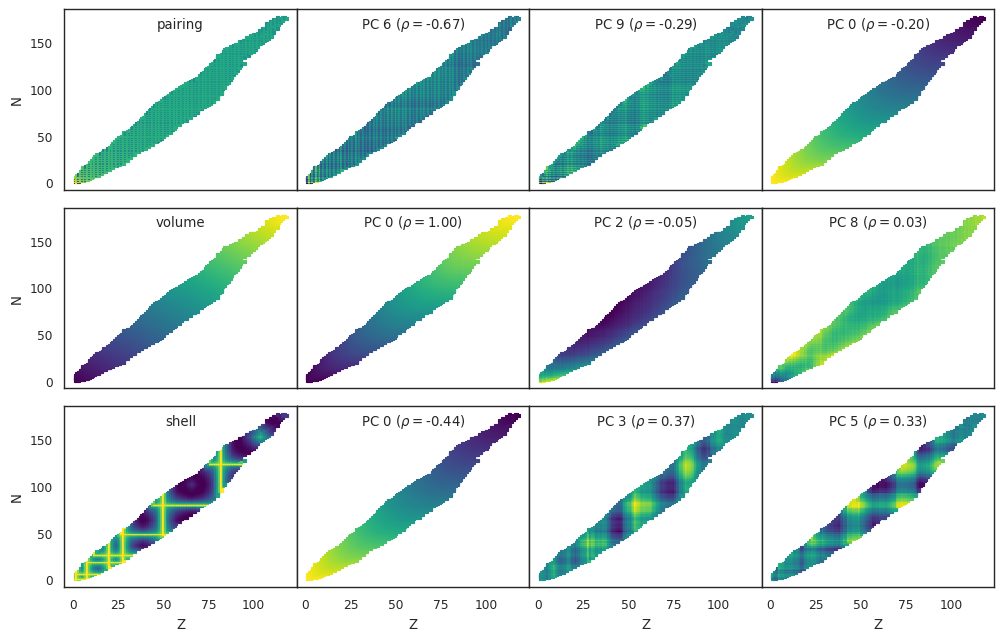

In [30]:
# let's pick pairing, volume, and shell terms to plot
sns.set_style('white')
cmap = "viridis"
terms = ["pairing", "volume", "shell"]
fig, axes = plt.subplots(len(terms), topk+1, figsize=(4*topk, 2.5*len(terms)), sharex=True, sharey=True)
for i, term in enumerate(physics_terms):
    if term not in terms: continue
    ax_idx = terms.index(term)
    plt.sca(axes[ax_idx, 0]); plt.scatter(Z, N, c=physics_terms[term], cmap=cmap, s=4, marker="s"); plt.title(term, y=0.85); plt.ylabel("N")
    for j, ax in enumerate(axes[ax_idx, 1:]):
        plt.sca(ax)
        corr = topk_vals[i, j]
        plt.scatter(Z, N, c=topk_nn[i, j]*np.sign(corr), cmap=cmap, s=4, marker="s")
        plt.title(f"PC {topk_idxs[i, j]} "r"($\rho=$"f"{corr:.2f})", y=0.85)
for ax in axes[-1]: ax.set_xlabel("Z")
# fig.tight_layout(h_pad=0, w_pad=0.1)

for ax in axes[:,0]:
    ax.set_position([0.05, 0.1, 0.3, 0.8]) 

for ax in axes[:,1]:
    ax.set_position([0.35, 0.1, 0.3, 0.8])

for ax in axes[:,2]:
    ax.set_position([0.65, 0.1, 0.3, 0.8])
fig.subplots_adjust(wspace=0, hspace=0.1) 
plt.savefig(f"plots/long-runs/{model_name}/matches.pdf")

## Embeddings Plot

Loading model from /export/d0/kitouni/data/experiments/long-runs/long_run-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0/ckpts/model.pt


/tmp/ipykernel_3813863/1755530291.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Z_emb[:, x_pc], Z_emb[:, y_pc], c=Z, cmap=cmap, s=4)


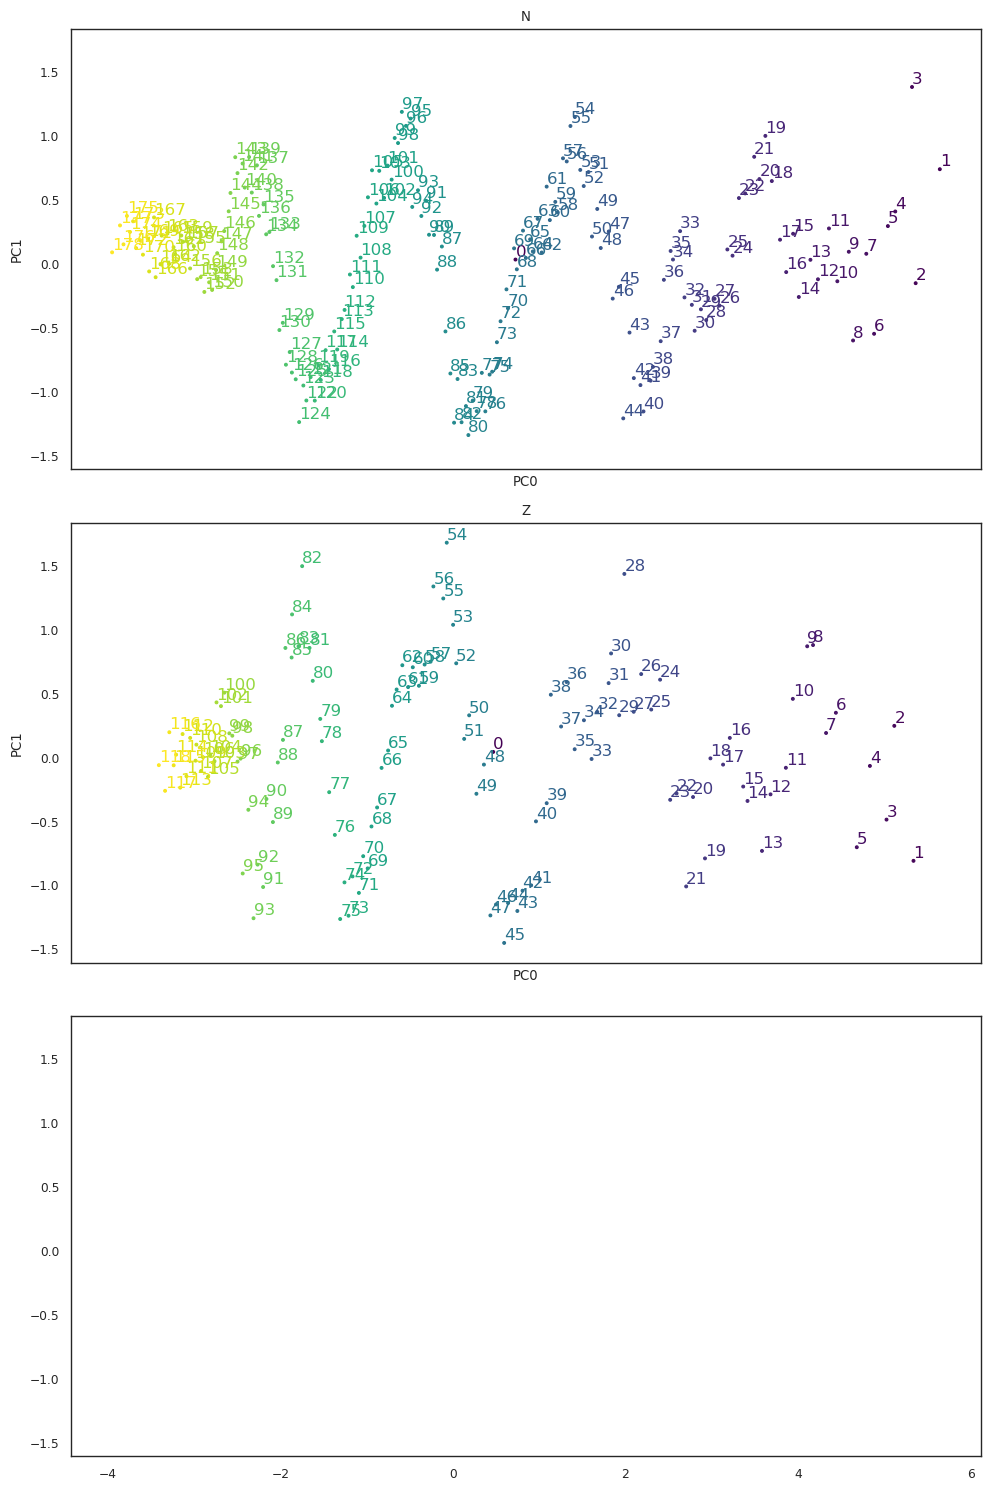

In [31]:
model_name = 'all'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

mask = data.train_mask & ~torch.isnan(data.y[:, 0])
X_train = data.X[mask]
y_train = data.y[mask]


import matplotlib as mpl
cmap = "viridis"

def get_embs(emb):
    emb = PCA(n_components=5).fit_transform(emb)
    Z = np.arange(len(emb))
    norm = mpl.colors.Normalize(vmin=min(Z), vmax=max(Z))
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    Z = sm.to_rgba(Z)
    return emb, Z

Z_emb, Z = get_embs(model.emb[0].detach().cpu().numpy())
N_emb, N = get_embs(model.emb[1].detach().cpu().numpy())

# plot the embeddings Z and N are the columns
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True, sharey=True)
# PC1 vs PC0
def plot_ax0(Z_emb, Z, ax, x_pc=0, y_pc=1, title="Z"):
    plt.sca(ax)
    plt.scatter(Z_emb[:, x_pc], Z_emb[:, y_pc], c=Z, cmap=cmap, s=4)
    PlottingContext.scatter_text(np.arange(len(Z)), Z_emb[:, x_pc], Z_emb[:, y_pc], colors=Z, ax=plt.gca())
    plt.xlabel("PC0"); plt.ylabel("PC1"); plt.title(title)

plot_ax0(N_emb, N, ax[0], title="N")
plot_ax0(Z_emb, Z, ax[1], title="Z")
# PC1 vs PC0
fig.tight_layout()


/tmp/ipykernel_1964272/3871849975.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Z_emb[:, x_pc], Z_emb[:, y_pc], c=Z, cmap=cmap, s=1)


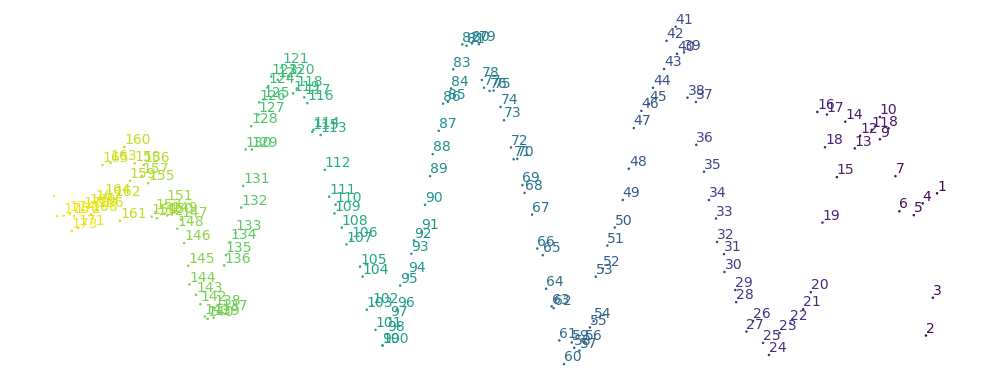

In [100]:
model_name = 'binding'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

mask = data.train_mask & ~torch.isnan(data.y[:, 0])
X_train = data.X[mask]
y_train = data.y[mask]


cmap = "viridis"

Z_emb, Z = get_embs(model.emb[0].detach().cpu().numpy())
N_emb, N = get_embs(model.emb[1].detach().cpu().numpy())

# plot the embeddings Z and N are the columns
fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)
# PC1 vs PC0
def plot_ax0(Z_emb, Z, ax, x_pc=0, y_pc=2, title="Z"):
    Z_emb = Z_emb[1:-1]
    Z = Z[1:-1]
    labels = np.arange(1, len(Z)-1)
    plt.sca(ax)
    plt.scatter(Z_emb[:, x_pc], Z_emb[:, y_pc], c=Z, cmap=cmap, s=1)
    PlottingContext.scatter_text(labels, Z_emb[:, x_pc], Z_emb[:, y_pc], colors=Z, ax=plt.gca(), fontsize=10)
    plt.xlabel("PC0"); plt.ylabel("PC1"); plt.title(title)

plot_ax0(N_emb, N, ax, title=None)
# PC1 vs PC0
plt.axis('off')
fig.tight_layout(w_pad=0, h_pad=0)
os.makedirs(f"plots/long-runs/{model_name}", exist_ok=True)
# plt.savefig(f"plots/long-runs/{model_name}/N-emb.pdf")



In [33]:
model.forward_with_embeddings(torch.tensor([[0, 0, 0]]), model.emb)

tensor([[0.4698, 0.5311, 0.5267, 0.5931, 0.6951, 0.3148, 0.3321, 0.5249, 0.2108,
         0.1125]], grad_fn=<AddmmBackward0>)